<a href="https://colab.research.google.com/github/gschink/DSBA_6010_Gschink/blob/main/Samll_Market_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is all in working order. It is built from https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb. Additional assets and views need to be supplied.  

In [3]:
!pip install PyPortfolioOpt

     |████████████████████████████████| 61 kB 7.6 MB/s 
     |████████████████████████████████| 2.8 MB 27.8 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [4]:
!pip install yfinance

     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 6.4 MB 32.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import BlackLittermanModel, black_litterman, risk_models, plotting, EfficientFrontier, objective_functions
import yfinance as yf

In [6]:
#need to pick additional assets

tickers = ["AAPL", "MSFT", "AMZN", "TSLA", "GOOGL", "JNJ", "JPM", "XOM"]

ohlc = yf.download(tickers)
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  8 of 8 completed


,AAPL,AMZN,GOOGL,JNJ,JPM,MSFT,TSLA,XOM
Date,,,,,,,,
2022-04-18,165.070007,3055.699951,2553.530029,177.660004,128.460007,280.519989,1004.289978,88.550003
2022-04-19,167.399994,3162.310059,2600.179932,183.080002,131.119995,285.299988,1028.150024,87.760002
2022-04-20,167.229996,3079.959961,2560.800049,183.889999,131.580002,286.359985,977.200012,87.959999
2022-04-21,166.419998,2965.919922,2496.290039,183.360001,130.559998,280.809998,1008.780029,87.029999
2022-04-22,161.789993,2887.000000,2392.709961,181.539993,126.809998,274.029999,1005.049988,85.129997


In [7]:
market_prices = yf.download("SPY")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    25.547979
1993-02-01    25.729689
1993-02-02    25.784197
1993-02-03    26.056765
1993-02-04    26.165787
Name: Adj Close, dtype: float64

In [8]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'AAPL': 2640315678720,
 'AMZN': 1468155035648,
 'GOOGL': 1581387481088,
 'JNJ': 477381197824,
 'JPM': 384023789568,
 'MSFT': 2054367215616,
 'TSLA': 1038729216000,
 'XOM': 362711678976}

In [9]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.673456983150675

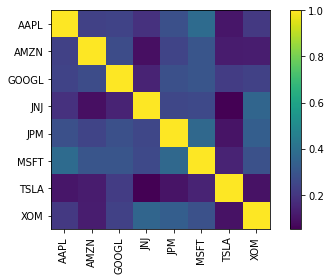

In [10]:
plotting.plot_covariance(S, plot_correlation=True);

In [11]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AAPL     0.166943
AMZN     0.127281
GOOGL    0.061040
JNJ      0.056420
JPM      0.090581
MSFT     0.110264
TSLA     0.059669
XOM      0.061047
dtype: float64

In [19]:
viewdict = {
    'AAPL': .05,
    'AMZN': .05,
    'GOOGL': 0,
    'JNJ': 0,
    'JPM': 0,
    'MSFT': .05,
    'TSLA': -.1,
    'XOM': 0
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In [20]:
confidences = [
               .5,
               .5,
               0,
               0,
               0,
               .5,
               1,
               0
]

In [21]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

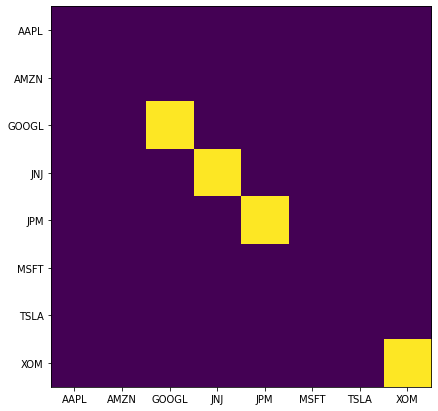

In [22]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [23]:
np.diag(bl.omega)

array([6.93716838e-03, 6.84788688e-03, 1.00000000e+06, 1.00000000e+06,
       1.00000000e+06, 3.43508272e-03, 0.00000000e+00, 1.00000000e+06])

In [34]:
intervals = [
    (-.25, 0.25),
    (-.25, 0.25),
    (-.25, 0.25),
    (-.25, 0.25),
    (-.25, 0.25),
    (-.25, 0.25),
    (-.25, 0.25),
    (-.25, 0.25)
]

In [35]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]


In [36]:
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [37]:
ret_bl = bl.bl_returns()
ret_bl

AAPL     0.131839
AMZN     0.095952
GOOGL    0.036342
JNJ      0.031521
JPM      0.060178
MSFT     0.081372
TSLA     0.030915
XOM      0.035203
dtype: float64

In [38]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.166943,0.131839,0.05
AMZN,0.127281,0.095952,0.05
GOOGL,0.061040,0.036342,0.00
JNJ,0.056420,0.031521,0.00
JPM,0.090581,0.060178,0.00
MSFT,0.110264,0.081372,0.05
TSLA,0.059669,0.030915,-0.10
XOM,0.061047,0.035203,0.00


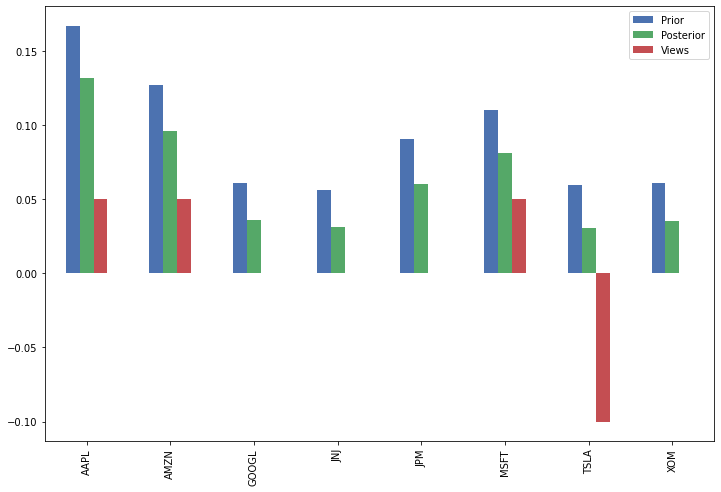

In [39]:
rets_df.plot.bar(figsize=(12,8));

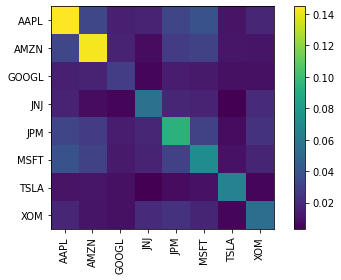

In [40]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [41]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


OrderedDict([('AAPL', 0.34008),
             ('AMZN', 0.22438),
             ('GOOGL', 0.04461),
             ('JNJ', 0.02713),
             ('JPM', 0.11137),
             ('MSFT', 0.18609),
             ('TSLA', 0.02849),
             ('XOM', 0.03784)])

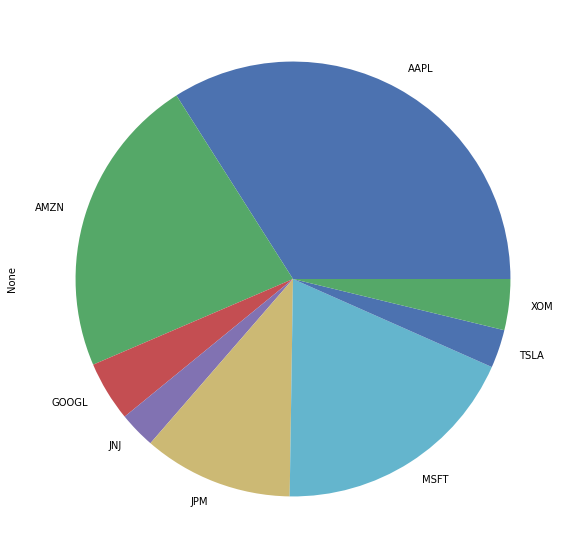

In [42]:
pd.Series(weights).plot.pie(figsize=(10,10));